# Imports / Set Up

In [1]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import sys

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# might have issues with too many files being opened at once
# this will prevent that
import torch.multiprocessing
import torch.nn.functional as f
from neuralop import H1Loss
from neuralop import LpLoss
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.utils import get_project_root
from torch import nn
from torch.utils.data import DataLoader

from operator_aliasing.utils import filter_batch
from operator_aliasing.utils import get_2d_low_pass_filter
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_model_preds
from operator_aliasing.utils import lowpass_filter_dataloader
from operator_aliasing.utils import get_2d_low_pass_filter

torch.multiprocessing.set_sharing_strategy('file_system')

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

device=device(type='cuda')


# Basic Filter to NeuralOp Data

In [2]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor


train_resolution = 16
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000,
    # batch_size=16,
    train_resolution=train_resolution,
    test_resolutions=[16, 32, 64, 128],
    n_tests=[100, 100, 100, 100],
    # test_batch_sizes=[32, 32, 32, 32],
)

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 64 with 32 samples 
Loading test db for resolution 128 with 32 samples 
Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 100 samples 
Loading test db for resolution 64 with 100 samples 
Loading test db for resolution 128 with 100 samples 


In [3]:
for _idx, batch in enumerate(train_loader):
    print(batch)
    sample = batch
    break

{'x': tensor([[[[1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  .

In [4]:
class lowpass_filter_2d(object):
    """Lowpass filter the image.

    Args:
        filter_limit: frequencies > filter_lim excluded
    """

    def __init__(self, filter_limit: int, img_size: int) -> None:
        assert isinstance(filter_limit, int)
        assert isinstance(img_size, int)
        self.filter_limit = filter_limit
        self.img_size = img_size

        # assert that filter limit is less than half img_size
        assert self.filter_limit <= self.img_size // 2

        # get filter
        self.filter = get_2d_low_pass_filter(self.filter_limit, self.img_size)

    def __call__(self, sample):
        model_input, label = sample['x'], sample['y']

        
        filter_input = filter_batch(self.filter, model_input)
        filter_label = filter_batch(self.filter, label)
        
        return {'x': filter_input, 'y': filter_label}
        

In [5]:
lowpass_transform = lowpass_filter_2d(3, 16)

lowpass_transform(sample)['x']

tensor([[[[ 0.4510,  0.4030,  0.3159,  ...,  0.5556,  0.5167,  0.4821],
          [ 0.6499,  0.5980,  0.4804,  ...,  0.7668,  0.7113,  0.6748],
          [ 0.8045,  0.7405,  0.5866,  ...,  0.9156,  0.8543,  0.8243],
          ...,
          [-0.0433, -0.0363, -0.0135,  ...,  0.1041,  0.0215, -0.0270],
          [ 0.0720,  0.0469,  0.0193,  ...,  0.1634,  0.1246,  0.0958],
          [ 0.2459,  0.2034,  0.1425,  ...,  0.3321,  0.3050,  0.2768]]],


        [[[ 0.9663,  0.8855,  0.7902,  ...,  0.6679,  0.8757,  0.9765],
          [ 0.8671,  0.7973,  0.7561,  ...,  0.6518,  0.8368,  0.9017],
          [ 0.7499,  0.7113,  0.7316,  ...,  0.6029,  0.7544,  0.7896],
          ...,
          [ 0.8597,  0.9363,  0.9275,  ...,  0.3574,  0.5388,  0.7170],
          [ 0.9471,  0.9489,  0.8710,  ...,  0.5045,  0.7013,  0.8597],
          [ 0.9956,  0.9390,  0.8275,  ...,  0.6194,  0.8298,  0.9629]]],


        [[[ 0.7097,  0.9081,  0.9828,  ...,  0.0211,  0.1766,  0.4359],
          [ 0.6775,  0.908

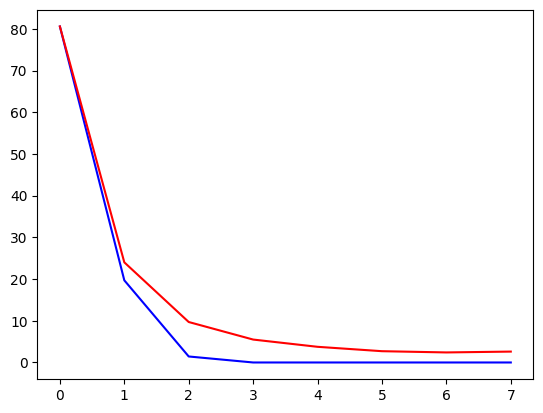

In [15]:
filtered_batch = lowpass_transform(sample)['x']

samples = 16
s = 16
filtered_sp = get_energy_curve(
    filtered_batch[:samples].reshape(samples * 1, s, s)
)

unfiltered_sp = get_energy_curve(
    sample['x'][:samples].reshape(samples * 1, s, s)
)

plt.plot(filtered_sp, color="blue", label="filtered")
plt.plot(unfiltered_sp, color="red", label="unfiltered")

# PDE BENCH

In [ ]:
# https://github.com/pdebench/PDEBench/blob/main/pdebench/models/fno/utils.py
from __future__ import annotations

import math as mt
from pathlib import Path

import h5py
import numpy as np
import torch
from torch.utils.data import Dataset


class FNODatasetSingle(Dataset):
    def __init__(
        self,
        filename,
        initial_step=10,
        saved_folder="../data/",
        reduced_resolution=1,
        reduced_resolution_t=1,
        reduced_batch=1,
        if_test=False,
        test_ratio=0.1,
        num_samples_max=-1,
    ):
        """

        :param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """

        # Define path to files
        root_path = Path(Path(saved_folder).resolve()) / filename
        if filename[-2:] != "h5":
            # print(".HDF5 file extension is assumed hereafter")

            with h5py.File(root_path, "r") as f:
                keys = list(f.keys())
                keys.sort()
                if "tensor" not in keys:
                    _data = np.array(
                        f["density"], dtype=np.float32
                    )  # batch, time, x,...
                    idx_cfd = _data.shape
                    if len(idx_cfd) == 3:  # 1D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                3,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f["pressure"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f["Vx"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch

                        self.grid = np.array(f["x-coordinate"], dtype=np.float32)
                        self.grid = torch.tensor(
                            self.grid[::reduced_resolution], dtype=torch.float
                        ).unsqueeze(-1)
                        # print(self.data.shape)
                    if len(idx_cfd) == 4:  # 2D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                idx_cfd[3] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                4,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f["pressure"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f["Vx"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch
                        # Vy
                        _data = np.array(
                            f["Vy"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 3] = _data  # batch, x, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing="ij")
                        self.grid = torch.stack((X, Y), axis=-1)[
                            ::reduced_resolution, ::reduced_resolution
                        ]

                    if len(idx_cfd) == 5:  # 3D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                idx_cfd[3] // reduced_resolution,
                                idx_cfd[4] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                5,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f["pressure"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f["Vx"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch
                        # Vy
                        _data = np.array(
                            f["Vy"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 3] = _data  # batch, x, t, ch
                        # Vz
                        _data = np.array(
                            f["Vz"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 4] = _data  # batch, x, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        z = np.array(f["z-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        z = torch.tensor(z, dtype=torch.float)
                        X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")
                        self.grid = torch.stack((X, Y, Z), axis=-1)[
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]

                else:  # scalar equations
                    ## data dim = [t, x1, ..., xd, v]
                    _data = np.array(
                        f["tensor"], dtype=np.float32
                    )  # batch, time, x,...
                    if len(_data.shape) == 3:  # 1D
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data = _data[:, :, :, None]  # batch, x, t, ch

                        self.grid = np.array(f["x-coordinate"], dtype=np.float32)
                        self.grid = torch.tensor(
                            self.grid[::reduced_resolution], dtype=torch.float
                        ).unsqueeze(-1)
                    if len(_data.shape) == 4:  # 2D Darcy flow
                        # u: label
                        _data = _data[
                            ::reduced_batch,
                            :,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        # if _data.shape[-1]==1:  # if nt==1
                        #    _data = np.tile(_data, (1, 1, 1, 2))
                        self.data = _data
                        # nu: input
                        _data = np.array(
                            f["nu"], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            None,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        self.data = np.concatenate([_data, self.data], axis=-1)
                        self.data = self.data[:, :, :, :, None]  # batch, x, y, t, ch

                        x = np.array(f["x-coordinate"], dtype=np.float32)
                        y = np.array(f["y-coordinate"], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing="ij")
                        self.grid = torch.stack((X, Y), axis=-1)[
                            ::reduced_resolution, ::reduced_resolution
                        ]

        elif filename[-2:] == "h5":  # SWE-2D (RDB)
            # print(".H5 file extension is assumed hereafter")

            with h5py.File(root_path, "r") as f:
                keys = list(f.keys())
                keys.sort()

                data_arrays = [
                    np.array(f[key]["data"], dtype=np.float32) for key in keys
                ]
                _data = torch.from_numpy(
                    np.stack(data_arrays, axis=0)
                )  # [batch, nt, nx, ny, nc]
                _data = _data[
                    ::reduced_batch,
                    ::reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                    ...,
                ]
                _data = torch.permute(_data, (0, 2, 3, 1, 4))  # [batch, nx, ny, nt, nc]
                gridx, gridy = (
                    np.array(f["0023"]["grid"]["x"], dtype=np.float32),
                    np.array(f["0023"]["grid"]["y"], dtype=np.float32),
                )
                mgridX, mgridY = np.meshgrid(gridx, gridy, indexing="ij")
                _grid = torch.stack(
                    (torch.from_numpy(mgridX), torch.from_numpy(mgridY)), axis=-1
                )
                _grid = _grid[::reduced_resolution, ::reduced_resolution, ...]
                _tsteps_t = torch.from_numpy(
                    np.array(f["0023"]["grid"]["t"], dtype=np.float32)
                )

                tsteps_t = _tsteps_t[::reduced_resolution_t]
                self.data = _data
                self.grid = _grid
                self.tsteps_t = tsteps_t

        if num_samples_max > 0:
            num_samples_max = min(num_samples_max, self.data.shape[0])
        else:
            num_samples_max = self.data.shape[0]

        test_idx = int(num_samples_max * test_ratio)
        if if_test:
            self.data = self.data[:test_idx]
        else:
            self.data = self.data[test_idx:num_samples_max]

        # Time steps used as initial conditions
        self.initial_step = initial_step

        self.data = self.data if torch.is_tensor(self.data) else torch.tensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, ..., : self.initial_step, :], self.data[idx], self.grid


class FNODatasetMult(Dataset):
    def __init__(
        self,
        filename,
        initial_step=10,
        saved_folder="../data/",
        if_test=False,
        test_ratio=0.1,
    ):
        """

        :param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """

        # Define path to files
        self.file_path = Path(saved_folder + filename + ".h5").resolve()

        # Extract list of seeds
        with h5py.File(self.file_path, "r") as h5_file:
            data_list = sorted(h5_file.keys())

        test_idx = int(len(data_list) * (1 - test_ratio))
        if if_test:
            self.data_list = np.array(data_list[test_idx:])
        else:
            self.data_list = np.array(data_list[:test_idx])

        # Time steps used as initial conditions
        self.initial_step = initial_step

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Open file and read data
        with h5py.File(self.file_path, "r") as h5_file:
            seed_group = h5_file[self.data_list[idx]]

            # data dim = [t, x1, ..., xd, v]
            data = np.array(seed_group["data"], dtype="f")
            data = torch.tensor(data, dtype=torch.float)

            # convert to [x1, ..., xd, t, v]
            permute_idx = list(range(1, len(data.shape) - 1))
            permute_idx.extend([0, -1])
            data = data.permute(permute_idx)

            # Extract spatial dimension of data
            dim = len(data.shape) - 2

            # x, y and z are 1-D arrays
            # Convert the spatial coordinates to meshgrid
            if dim == 1:
                grid = np.array(seed_group["grid"]["x"], dtype="f")
                grid = torch.tensor(grid, dtype=torch.float).unsqueeze(-1)
            elif dim == 2:
                x = np.array(seed_group["grid"]["x"], dtype="f")
                y = np.array(seed_group["grid"]["y"], dtype="f")
                x = torch.tensor(x, dtype=torch.float)
                y = torch.tensor(y, dtype=torch.float)
                X, Y = torch.meshgrid(x, y, indexing="ij")
                grid = torch.stack((X, Y), axis=-1)
            elif dim == 3:
                x = np.array(seed_group["grid"]["x"], dtype="f")
                y = np.array(seed_group["grid"]["y"], dtype="f")
                z = np.array(seed_group["grid"]["z"], dtype="f")
                x = torch.tensor(x, dtype=torch.float)
                y = torch.tensor(y, dtype=torch.float)
                z = torch.tensor(z, dtype=torch.float)
                X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")
                grid = torch.stack((X, Y, Z), axis=-1)

        return data[..., : self.initial_step, :], data, grid

In [ ]:
data = FNODatasetSingle(
        filename="2D_DarcyFlow_beta0.01_Train.hdf5",
        initial_step=10,
        saved_folder="/pscratch/sd/m/mansisak/PDEBench/pdebench_data/2D/DarcyFlow/",
        reduced_resolution=1,
        reduced_resolution_t=1,
        reduced_batch=7,
        if_test=False,
        test_ratio=0.1,
        num_samples_max=-1,
    )

print(data[0][1].shape)
initial = data[0][0]
label = data[0][1]
grid = data[0][2]

In [ ]:
torch.equal(initial, label)

In [ ]:
plt.imshow(initial[:,:, 1, 0])

In [ ]:
plt.imshow(label[:,:, 1, 0])

In [ ]:
plt.imshow(grid[:,:, 1])

# TODO: produce data loader which can apply a specific filter and use it to train the model!!